In [1]:
import numpy as np
from numpy import r_
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure,plot, title,stem, loglog,xlabel,ylabel
import bitarray, time, urllib, ssl
from scipy import signal, integrate
#from math import gcd
from fractions import gcd
from functools import reduce
from numpy import ones,zeros, pi, cos, exp, sign
from scipy import misc
import serial
import sounddevice as sd
%matplotlib inline

In [2]:
def lcm(numbers):
    return reduce(lambda x,y: (x*y)//gcd(x,y), numbers, 1)

In [233]:
def afsk1200(bits, fs = 48000):
    # the function will take a bitarray of bits and will output an AFSK1200 modulated signal of them, sampled at fs Hz
    #  Inputs:
    #         bits  - bitarray of bits
    #         fs    - sampling rate
    # Outputs:
    #         sig    -  returns afsk1200 modulated signal samples at fs Hz
    
    
    # your code below:
    fs_eff = lcm((fs, 1200))
    bit_length = fs_eff//1200 #Each bit's duration is the sampling rate (samples/s) / (bits/s) => samples/bit
    num_samples = bit_length * len(bits) #The total number of samples is the bit length * # bits
    tot_time = num_samples/fs_eff #converts samples to time using sample rate 
    #change the bitstream to be between -1 and 1 instead of 0 and 1
    m = np.zeros(num_samples)
    
    #Expands the bitstream to its full length, basically inserting bit_length copies of each bit into the stream 
    cur_idx = 0
    for bit in bits:
        for i in range(0, bit_length): 
            if bit == 1:
                m[cur_idx] = bit
            if bit == 0 or bit == -1:
                m[cur_idx] = -1
            cur_idx += 1    
    t = np.linspace(0, tot_time, num_samples) #time indices for the integration 
    func = lambda time: m[time]
    integrated = np.array(integrate.cumtrapz(m, t, initial=0)) #integrates over m to ensure smooth frequency transitions
    sig = np.cos(2*np.pi*1700*t + 2*np.pi*500*integrated) #The actual signal is a series of cosines at 1200 Hz and 2200 Hz
    sig = sig[::fs_eff//fs]
    return sig

def nc_afsk1200Demod(sig, fs=48000.0, TBW=2.0):
    #  non-coherent demodulation of afsk1200
    # function returns the NRZ (without rectifying it)
    # 
    # sig  - signal
    # baud - The bitrate. Default 1200
    # fs   - sampling rate in Hz
    # TBW  - TBW product of the filters
    #
    # Returns:
    #     NRZ 
    
    # your code here
    baud = 1200
    num_taps = np.ceil(TBW/1200*fs+1)
    t = np.linspace(0, TBW/1200*fs+1, num_taps)
    bp1 = signal.firwin(num_taps, 2*(baud)/fs) * np.exp(2 * np.pi *1j* 1200/fs*t)
    bp2 = signal.firwin(num_taps, 2*(baud)/fs) * np.exp(2 * np.pi *1j* 2200/fs*t)
    lpf = signal.firwin(num_taps, 2*(baud)/fs)
#     freqs, power = avgPS(bp1, N=21, fs=fs)
#     freqs2, power2 = avgPS(bp2, N=21, fs=fs)
#     freqs3, power3 = avgPS(lpf, N=21, fs=fs)
#     plt.plot(freqs, power)
#     plt.plot(freqs2, power2)
#     plt.plot(freqs3, power3)
#     plt.figure()
#     fig = figure(figsize=(16,4))
    sig_mark = np.abs(np.convolve(sig, bp1, mode="same"))
    sig_space = np.abs(np.convolve(sig, bp2, mode="same"))
#     plt.plot(sig_mark[0:4800])
#     plt.plot(sig_space[0:4800])

    nrz = np.convolve(-sig_mark + sig_space, lpf, mode="same")
    return nrz

def PLL(NRZa, a = 0.74 , fs = 48000, baud = 1200):
    # 
    # function implements a simple phased lock loop for timing recovery
    #
    # Inputs:
    #          NRZa -   The NRZ signal
    #          a - nudge factor
    #          fs - sampling rate (arbitrary)
    #          baude  - the bit rate
    #
    # Outputs:
    #          bits: bits that were samples
    #          idx: inidicies of the original message that were sampled. 
    #
    tick = (2**32)//(fs//baud)
    print(tick)
    pll = np.int32(0)
    idx = []
    for i in range(0, len(NRZa)):
        if i != 0 and np.sign(NRZa[i-1]) != np.sign(NRZa[i]): #zero crossing
            pll = np.int32(pll * a)
        tmp = pll
        pll = np.int32(np.int32(pll)+np.int32(tick))
        if (pll < tmp):
            #pll = 0
            idx.append(i) #this is a sample since the pll has overflowed 
    bits =  bitarray.bitarray((NRZa[idx]>0).tolist())
    return bits, idx

In [263]:
#Now trying AFSK 
#with a center frequency of 1800, for 2400 baud, we can get two frequencies of 1000 Hz and 2400 Hz 
def afsk1200(bits, fc, df, baud, fs):
    fs_eff = lcm((fs, baud))
    bit_length = fs_eff//baud #Each bit's duration is the sampling rate (samples/s) / (bits/s) => samples/bit
    num_samples = bit_length * len(bits) #The total number of samples is the bit length * # bits
    tot_time = num_samples/fs_eff #converts samples to time using sample rate
    #change the bitstream to be between -1 and 1 instead of 0 and 1
    m = np.zeros(num_samples)
    #Expands the bitstream to its full length, basically inserting bit_length copies of each bit into the stream
    cur_idx = 0
    for bit in bits:
        for i in range(0, bit_length): 
            if bit == 1:
                m[cur_idx] = bit
            if bit == 0 or bit == -1:
                m[cur_idx] = -1
            cur_idx += 1
    t = np.linspace(0, tot_time, num_samples) #time indices for the inte gration
    func = lambda time: m[time]
    integrated = np.array(integrate.cumtrapz(m, t, initial=0)) #integrat es over m to ensure smooth frequency transitions
    sig = np.cos(2*np.pi*fc*t + 2*np.pi*df*integrated) #The actual si gnal is a series of cosines at 1200 Hz and 2200 Hz
    sig = sig[::fs_eff//fs] 
    return sig

def nc_afsk1200Demod(sig, fc, df, baud, fs=48000, TBW=2):
    #  non-coherent demodulation of afsk1200
    # function returns the NRZ (without rectifying it)
    # 
    # sig  - signal
    # baud - The bitrate. Default 1200
    # fs   - sampling rate in Hz
    # TBW  - TBW product of the filters
    #
    # Returns:
    #     NRZ 
    t = np.linspace(0, TBW/baud*fs+1, TBW/baud*fs+1) 
    bpp = signal.firwin(TBW/baud*fs+1, 2*(2*df)/fs) * np.exp(2 * np.pi * 1j * (fc/fs)*t)
    bp1 = signal.firwin(TBW/baud*fs+1, 2*(baud)/fs) * np.exp(2 * np.pi * 1j* (fc - df)/fs*t)
    bp2 = signal.firwin(TBW/baud*fs+1, 2*(baud)/fs) * np.exp(2 * np.pi * 1j* (fc + df)/fs*t)
    lpf = signal.firwin(TBW/baud*fs+1, 2*(baud)/fs)
    sig = np.convolve(sig, bpp, mode="same")

    sig_mark = np.abs(np.convolve(sig, bp1, mode="same"))
    sig_space = np.abs(np.convolve(sig, bp2, mode="same"))
    nrz = np.convolve(-sig_mark + sig_space, lpf, mode="same") 
    return nrz

def PLL(NRZa, a = 0.74 , fs = 48000, baud = 1200): 
    # function implements a simple phased lock loop for tyming recovery
    #
    # Inputs:
    #          NRZa -   The NRZ signal
    #          a - nudge factor
    #          fs - sampling rate (arbitrary)
    #          baude  - the bit rate
    #
    # Outputs:
    # idx - array of indexes to sample at #
    tick = (2**32)//(fs//baud)
    pll = np.int32(0)
    idx = []
    for i in range(0, len(NRZa)):
        if i != 0 and np.sign(NRZa[i-1]) != np.sign(NRZa[i]): #zero cros
            pll = np.int32(pll * a)
        tmp = pll
        pll = np.int32(np.int32(pll)+np.int32(tick)) 
        if (pll < tmp):
            idx.append(i) #this is a sample since the pll has overflowed
    bits =  bitarray.bitarray((NRZa[idx]>0).tolist())
    return bits, idx

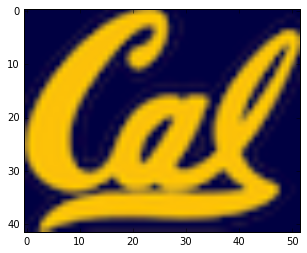

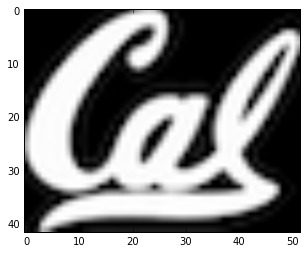

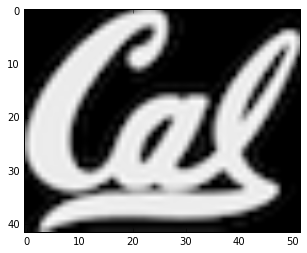

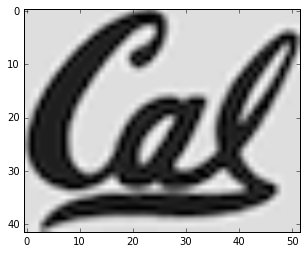

In [264]:
# load a image
fname = '../images/calBlue.tiff'
image = misc.imread(fname)

plt.imshow(image)
plt.show()

plt.imshow(image[:,:,0], cmap = 'gray')
plt.show()

plt.imshow(image[:,:,1], cmap = 'gray')
plt.show()

plt.imshow(image[:,:,2], cmap = 'gray')
plt.show()

In [265]:
# utility functions
def int_to_bit_arr(num, size):
    assert 2**size > num
    b_arr = np.zeros(size, dtype = int)
    div = 2**(size - 1)
    for i in range(size):
        b_arr[i] = num//div
        num -= b_arr[i] * div
        div = div//2
    return b_arr

def bit_array_to_int(bit_arr):
    size = len(bit_arr)
    num = np.int(0)
    p = 2**(size - 1)
    for digit in bit_arr:
        num += digit*p
        p = p//2
    return num

# function to encode a image nxmx3 uint8 arrray 
def img_to_bit_arr(img):
    image_h = img.shape[0]
    image_w = img.shape[1]
    bit_arr = np.zeros(image_h*image_w*3*8, dtype = int)
    for i in range(image_h):
        for j in range(image_w):
            curr_pixel = i*image_w + j
            chunk = np.concatenate((int_to_bit_arr(img[i][j][0],8), int_to_bit_arr(img[i][j][1],8), int_to_bit_arr(img[i][j][2],8)))
#             print(chunk)
            bit_arr[curr_pixel*24:curr_pixel*24 + 24] = chunk
    return bit_arr
 # extract image dimentions
image_h = image.shape[0]
image_w = image.shape[1]

In [266]:
##parameters for 2400 baud
# fc = 3067
# df = 902
# baud = 2400

##parameters for 1200 baud
fc1 = 3000
df1 = 600
baud1 = 2400

fs = 48000

In [267]:
# packet format
# |preamble| 11 bit - final height | 11 bit - final width | 11 bit - tx height | 11 bit - tx width | message data
preamble_sync = np.array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,])
# preamble_sync = np.concatenate((preamble_sync, preamble_sync))# start out with a 16 bit sync so that the PLL can lcok
preamble_len = 256
preamble_code = np.random.randint(2, size = preamble_len) #then add a PR sequence to correlate to
print(preamble_code)
preamble = np.concatenate((preamble_sync, preamble_code))

fs = 48000
#downsampling code
tx_time = image_h*image_w*24 / 1200
tx_img = image
tx_img_h = image_h
tx_img_w = image_w
print("original tx time: "+str(tx_time))
max_tx_time = 30
# if(tx_time > max_tx_time):
# #     down sample
#     scaling = max_tx_time / tx_time 
# #     tx_img_h = np.floor(scaling*image_h).astype(int)
# #     tx_img_w = np.floor(scaling*image_w).astype(int)
#     tx_img_h = image_h//2
#     tx_img_w = image_w
    
#     tx_img = np.zeros((tx_img_h, tx_img_w, 3))
# #     tx_img[:,:,0] = signal.resample(signal.resample(image[:,:,0], tx_img_w, axis = 1), tx_img_h, axis =0)
# #     tx_img[:,:,1] = signal.resample(signal.resample(image[:,:,1], tx_img_w, axis = 1), tx_img_h, axis =0)
# #     tx_img[:,:,2] = signal.resample(signal.resample(image[:,:,2], tx_img_w, axis = 1), tx_img_h, axis =0)

#     tx_img[:,:,0] = signal.resample(image[:,:,0], tx_img_h, axis = 0)
#     tx_img[:,:,1] = signal.resample(image[:,:,1], tx_img_h, axis = 0)
#     tx_img[:,:,2] = signal.resample(image[:,:,2], tx_img_h, axis = 0)
#     tx_img = np.array(tx_img, dtype = np.uint8)
    
#     plt.imshow(tx_img)
#     plt.show()
    
#     plt.imshow(tx_img[:,:,0], cmap = 'gray')
#     plt.show()
    
#     plt.imshow(tx_img[:,:,1], cmap = 'gray')
#     plt.show()
    
#     plt.imshow(tx_img[:,:,2], cmap = 'gray')
#     plt.show()

# pack the meta-data
meta_data = np.concatenate((int_to_bit_arr(image_h, 11), int_to_bit_arr(image_w, 11), int_to_bit_arr(tx_img_h, 11), int_to_bit_arr(tx_img_w, 11)))
msg_data = img_to_bit_arr(tx_img)

msg = np.concatenate((preamble, meta_data, msg_data))
sig_tx = afsk1200(msg, fc=fc1, df=df1, baud=baud1, fs = fs)

print(len(sig_tx)/fs)

[0 1 0 1 1 1 1 1 0 0 1 1 0 0 1 0 1 0 0 0 1 1 0 1 0 0 0 1 1 1 1 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 1 1 1 0 1 0 0 0 1 0 0 1 0 1 0 1 0 0 0 1 0 1
 1 0 0 1 0 0 1 0 1 0 1 0 1 0 0 1 0 0 0 1 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 0 1
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 0
 1 0 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0
 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 1 1 1 0 1 0 1
 0 1 0 0 0 0 1 1 1 0 0 1 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 1 0 1 1 1 1 0]
original tx time: 43.68
21.971666666666668


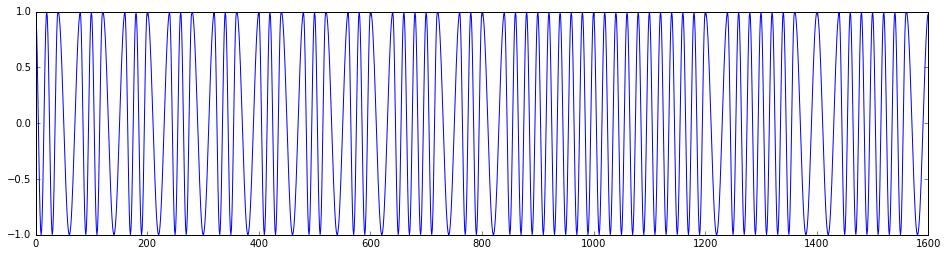

In [133]:
plt.figure(figsize = (16,4))
plt.plot(sig_tx[0:40*40])

In [8]:
# use device manager to figure shit out
port = serial.Serial('/dev/tty.SLAB_USBtoUART')

In [239]:
port.setDTR(False)
time.sleep(1)
port.setDTR(True)

In [149]:
port.close()

In [10]:
sd.query_devices()

> 0 Built-in Microphone, Core Audio (2 in, 0 out)
< 1 Built-in Output, Core Audio (0 in, 2 out)
  2 USB Audio Device, Core Audio (1 in, 2 out)

In [35]:
# Your code here:
# builtin_idx = 2

# port.setDTR(False)
# time.sleep(.5)
# # play sound on builtin interface and listen through the speaker  
# t = np.linspace(0,3,fs*3)
# sig_tx = np.sin(2*np.pi*1200*t)
# tx_time = len(sig_tx) / fs
# sig_tx_padded = 0.8*np.concatenate((sig_tx,np.zeros(fs//2)))
# sig_rx = sd.playrec(sig_tx_padded,samplerate=fs, device=2, channels = 1)
# time.sleep(1.1 * tx_time)
# port.setDTR(True)

# sig_rx = sig_rx.flatten()
# # myspectrogram_hann_ovlp(msg, 80, fs, 0)

In [18]:
# rec = sd.rec(int(5 * fs), samplerate=fs, channels=1)
# sd.wait(6)
sd.play(sig_rx, fs)

(168000,)


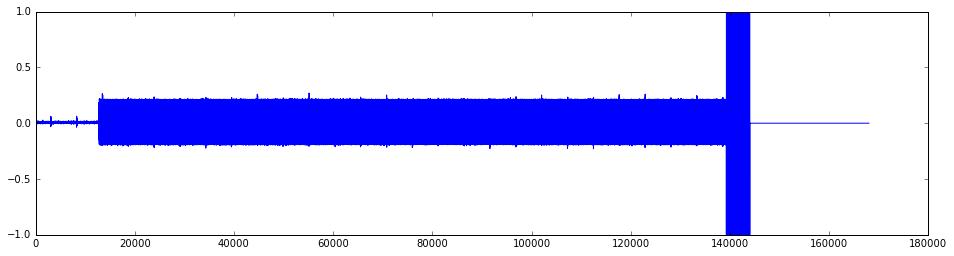

In [36]:
plt.figure(figsize = (16,4))
plt.plot(sig_rx)
print(sig_rx.shape)

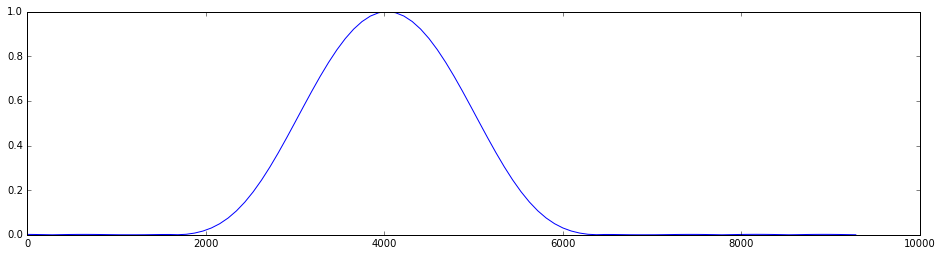

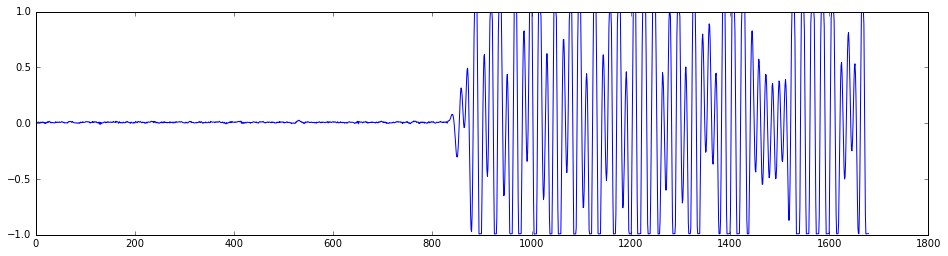

In [257]:
# simulation 
# for now we'll just add awgn and pad the signal to mimic the rx padding that will happen
sig_rx = np.concatenate((np.zeros(12000), sig_tx, np.zeros(12000)))
# lf = pi / fs * 1000
# hf = pi / fs * 3000
TBW = 2.0
#num_taps = np.floor((TBW/baud*fs+1)).astype(int)
num_taps = 127
t = np.linspace(0, num_taps, num_taps)
h_bp = signal.firwin(num_taps, (1000)/fs) * np.exp(2 * np.pi *1j* 2000/fs*t)
w, resp = signal.freqz(h_bp)
w = w * fs/np.pi
plt.figure(figsize = (16,4))
plt.plot(w[0:100], np.abs(resp[0:100]))



tx_time = len(sig_tx)/fs
port.setDTR(False)
sig_rx = sd.playrec(sig_tx,samplerate=fs, device=2, channels = 1)
time.sleep(1.1 * tx_time)
port.setDTR(True)
#sig_rx = np.convolve(sig_rx, h_bp, mode = 'same')

#sig_rx = sig_rx + 0.1*np.random.randn(len(sig_rx))

plt.figure(figsize = (16,4))
plt.plot(sig_rx[12000 - 80:12000 + 40*40])

In [70]:
port.setDTR(True)

In [258]:
sig_rx = sig_rx.reshape(1, len(sig_rx))[0]

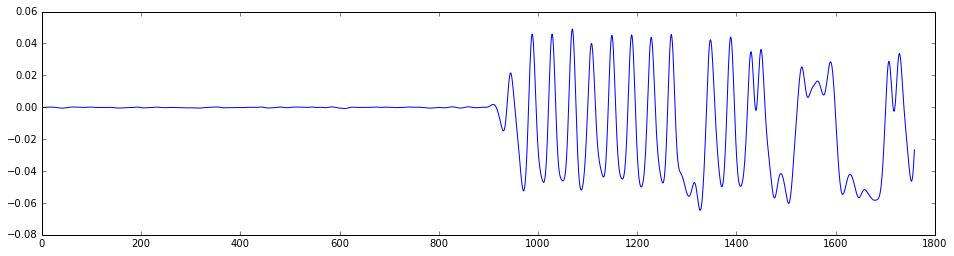

In [259]:
nrz_sig1 = nc_afsk1200Demod(sig_rx, fc=fc1, df=df1, baud=baud1, fs = fs)
plt.figure(figsize = (16,4))
plt.plot(nrz_sig1[12000 - 160:12000 + 40*40])

In [260]:
raw_bits, idx = PLL(nrz_sig1, baud=baud1, fs = fs)
raw_bits = np.array(raw_bits, dtype = int)
print(idx[40:60])

[807, 827, 847, 869, 888, 908, 928, 948, 968, 986, 1006, 1026, 1046, 1066, 1086, 1106, 1126, 1148, 1168, 1188]


/Users/Hersh/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:67: RuntimeWarning: overflow encountered in int_scalars


52475
52730
653


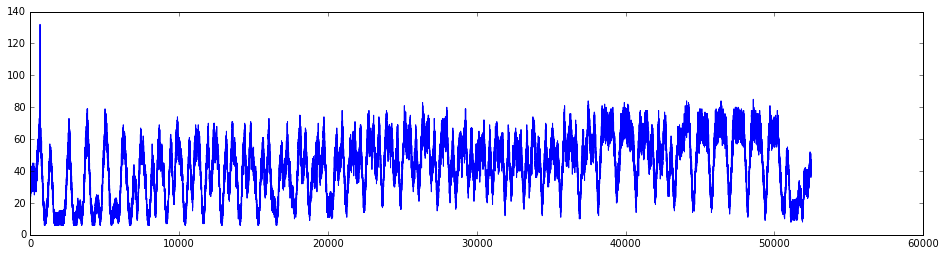

In [261]:
preamble_find = np.correlate(raw_bits,preamble_code, mode = 'valid')
plt.figure(figsize = (16,4))
print(len(preamble_find))
print(len(raw_bits))
plt.plot(preamble_find)

start = np.argmax(preamble_find)
print(start)
# rx_preamble = raw_bits[start:start + 128]
# print(np.dot(rx_preamble, preamble_code.T))

(42, 52, 3)


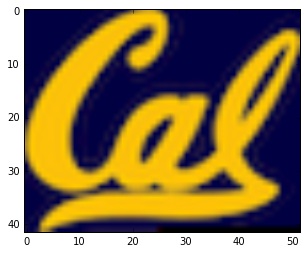

In [262]:
rx_meta_data_bits = raw_bits[start+preamble_len:start+preamble_len+44]
rx_data_start = start+preamble_len+44

rx_img_final_height = bit_array_to_int(rx_meta_data_bits[0:11])
rx_img_final_width = bit_array_to_int(rx_meta_data_bits[11:22])
rx_img_data_height = bit_array_to_int(rx_meta_data_bits[22:33])
rx_img_data_width = bit_array_to_int(rx_meta_data_bits[33:44])

rx_data_len = rx_img_data_height*rx_img_data_width*24
rx_data_bits = raw_bits[rx_data_start:rx_data_start + rx_data_len]

rx_img_raw = np.zeros((rx_img_data_height, rx_img_data_width, 3), dtype = np.uint8)

for i in range(rx_img_data_height):
    for j in range(rx_img_data_width):
        curr_pix = i*rx_img_data_width + j
        chunk = rx_data_bits[curr_pix*24:curr_pix*24 + 24]
        rx_img_raw[i][j][0] = bit_array_to_int(chunk[0:8])
        rx_img_raw[i][j][1] = bit_array_to_int(chunk[8:16])
        rx_img_raw[i][j][2] = bit_array_to_int(chunk[16:24])

print(rx_img_raw.shape)
plt.imshow(rx_img_raw)
plt.show()


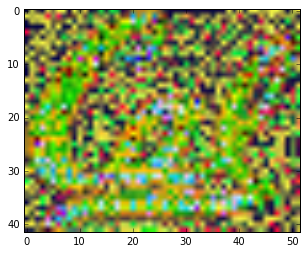

In [55]:
rx_img_up_sample = np.zeros((rx_img_final_height, rx_img_final_width, 3))
rx_img_up_sample[:,:,0] = signal.resample(signal.resample(rx_img_raw[:,:,0], rx_img_final_width, axis = 1), rx_img_final_height, axis =0)
rx_img_up_sample[:,:,1] = signal.resample(signal.resample(rx_img_raw[:,:,1], rx_img_final_width, axis = 1), rx_img_final_height, axis =0)
rx_img_up_sample[:,:,2] = signal.resample(signal.resample(rx_img_raw[:,:,2], rx_img_final_width, axis = 1), rx_img_final_height, axis =0)

rx_img_up_sample = np.array(rx_img_up_sample, dtype = np.uint8)

plt.imshow(rx_img_up_sample)
plt.show()